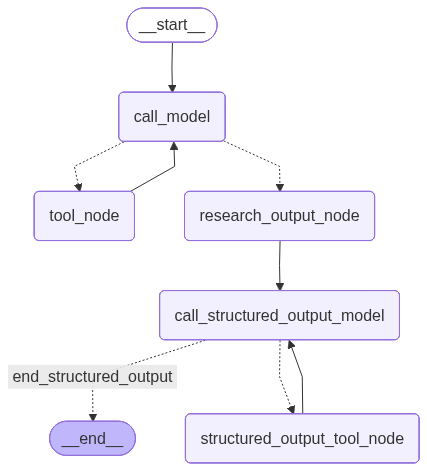

In [10]:
from __future__ import annotations
import os 

from langgraph.types import Command  
from langgraph.graph import StateGraph, START, END  
from typing_extensions import TypedDict, Annotated  
from typing import List, Dict, Any, Optional, Sequence, Literal 
from langchain_core.messages import AnyMessage, BaseMessage, ToolMessage, SystemMessage, HumanMessage, filter_messages   
from langchain_openai import ChatOpenAI  
from dataclasses import dataclass  
from pydantic import BaseModel, Field  
import aiohttp 
import operator   
import os   
from firecrawl import AsyncFirecrawlApp   
from langchain.agents import create_agent  
from langchain_core.prompts import PromptTemplate 
from tavily import AsyncTavilyClient 
from dotenv import load_dotenv 
from langchain.tools import ToolRuntime, tool    
from research_agent.agent_tools.tavily_functions import tavily_search, format_tavily_search_response    
from research_agent.agent_tools.firecrawl_functions import firecrawl_scrape, format_firecrawl_map_response, format_firecrawl_search_response, firecrawl_map, format_firecrawl_map_response 
from research_agent.medical_db_tools.pub_med_tools import ( 
   pubmed_literature_search_tool 
)   
from IPython.display import Image, display  





load_dotenv() 

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 

tavily_api_key = os.getenv("TAVILY_API_KEY") 
async_tavily_client = AsyncTavilyClient(api_key=tavily_api_key) 

firecrawl_api_key = os.getenv("FIRECRAWL_API_KEY") 
async_firecrawl_app = AsyncFirecrawlApp(api_key=firecrawl_api_key) 


ResearchType = Literal["general", "medical", "casestudy"] 


class DirectionResearchResult(BaseModel):
    direction_id: str
    summary: str
    key_findings: List[str]
    citations: List[str]          # URLs, DOIs, etc.
    file_refs: List[str]          # FS/S3 paths for offloaded content
    notes: str  


# This feeds the prompt as well 

class ResearchDirection(BaseModel):
    id: str
    title: str
    description: str              # what to investigate
    research_type: ResearchType   # "general" / "medical" / "casestudy"
    query_seed: str               # initial search term
    priority: int = 1
    max_steps: int = 5    

class ResearchState(TypedDict, total=False):  
    # Core tool-loop plumbing
    messages: Annotated[Sequence[BaseMessage], operator.add]
    llm_calls: int
    tool_calls: int

    # Context / config for this direction
    direction: ResearchDirection
    episode_context: str          # short summary of episode, guest, etc.

    # Accumulated research data
    research_notes: Annotated[List[str], operator.add]     # human-readable notes from each step
    citations: Annotated[List[str], operator.add]          # URLs / DOIs
    file_refs: List[str]          # paths you wrote to FS/S3
    steps_taken: int 

    structured_outputs: Annotated[List[BaseModel], operator.add] = []   

    # Final structured result
    result: DirectionResearchResult


research_model = ChatOpenAI(
    model="gpt-5-mini", 
    reasoning={ 
        "effort": "medium", 
    },
    temperature=0.0,
    output_version="responses/v1",
    max_retries=2,
) 

summary_model = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0.0,
    output_version="responses/v1",
    max_retries=2,
) 

structured_output_model = ChatOpenAI(
    model="gpt-5-mini", 
    reasoning={ 
        "effort": "medium", 
    },
    temperature=0.0,
    output_version="responses/v1",
    max_retries=2,
)


class Citation(BaseModel): 
    url: str = Field(..., description="The URL of the source")  
    title: str = Field(..., description="The title of the source")   

class TavilyResultsSummary(BaseModel):  
    summary: str = Field(..., description="An extensive  summary of the search results")   
    citations: List[Citation] = Field(..., description="The citations of the search results")   

class FirecrawlResultsSummary(BaseModel):  
    summary: str = Field(..., description="A faithful summary of the markdown representation of the content")

    citations: List[Citation] = Field(..., description="A summary of the markdown of the content")  

# This is more extensive 
async def summarize_tavily_web_search(search_results: str, summary_prompt: str) -> TavilyResultsSummary:  
    agent_instructions = summary_prompt.format(search_results=search_results) 
    web_search_summary_agent = create_agent( 
        summary_model, 
        response_format=TavilyResultsSummary, 

    )   

    web_search_summary_agent_response = await web_search_summary_agent.ainvoke(
        {"messages": [{"role": "user", "content": agent_instructions}]}
    )


    return web_search_summary_agent_response["structured_response"]



# This is more extensive 
async def summarize_firecrawl_scrape(search_results: str, summary_prompt: str) -> FirecrawlResultsSummary:  
    agent_instructions = summary_prompt.format(search_results=search_results) 
    web_search_summary_agent = create_agent( 
        summary_model, 
        response_format=FirecrawlResultsSummary, 

    )   

    web_search_summary_agent_response = await web_search_summary_agent.ainvoke(
        {"messages": [{"role": "user", "content": agent_instructions}]}
    )


    return web_search_summary_agent_response["structured_response"]


SUMMARY_PROMPT = """ 
Please summarize the following web search content faithfully and return structured output 

<Placeholder> 

{search_results}

""" 


@tool(description="Use firecrawl map to get all of the urls based off of a url") 
async def firecrawl_map_tool( 
    url: str, 
     search: Optional[str] = None,
    include_subdomains: Optional[bool] = None,
    limit: Optional[int] = None,
    sitemap: Optional[Literal["only", "include", "skip"]] = None,
   
   
) -> str:  

    result = await firecrawl_map(async_firecrawl_app, 
    url, 
    search, 
    include_subdomains, 
    limit, 
    sitemap, 
     

    ) 

    formatted_result = format_firecrawl_map_response(result) 

    return formatted_result  

FIRECRAWL_SCRAPE_PROMPT = """ 

Place holder 

"""  

@tool(description="Use firecrawl scrape to get the markdown or text content of a url for easy readability") 
async def firecrawl_scrape_tool(  
    runtime: ToolRuntime,  
    url: str,  
    formats: Optional[List[Literal["markdown", "html", "raw", "screenshot"]]] = None,
    include_links: bool = False,
    max_depth: int = 0,
    include_images: bool = False,
) -> str: 
    results = await firecrawl_scrape(async_firecrawl_app, 
    url, 
    formats, 
    include_links, 
    max_depth, 
    include_images 
    ) 

    formatted_results = format_firecrawl_search_response(results)  


    summary_of_scrape = await summarize_firecrawl_scrape(formatted_results, FIRECRAWL_SCRAPE_PROMPT )  

    runtime.state.get("citations").extend([citation.url for citation in summary_of_scrape.citations])
    runtime.state.get("research_notes").append(summary_of_scrape.summary)

    formatted_scrape_summary = format_summary_results(summary_of_scrape) 

    return formatted_scrape_summary 




def format_summary_results(web_search_summary: TavilyResultsSummary | FirecrawlResultsSummary) -> str: 
    lines: List[str] = [] 
    lines.append("=== Web Search Summary ===") 
    lines.append(web_search_summary.summary) 
    lines.append("") 
    lines.append("=== Citations ===") 
    for citation in web_search_summary.citations: 
        lines.append(f"- {citation.url} - {citation.title}") 
    return "\n".join(lines) 

@tool(description="Search the web for information about a specific topic or query") 
async def tavily_web_search_tool(   
    runtime: ToolRuntime,  
    query: str,  

    max_results: int = 5, 
    search_depth: Literal["basic", "advanced"] = "basic",  
    topic: Optional[Literal["general", "news", "finance"]] = "general", 
    include_images: bool = False,  
    include_raw_content: bool | Literal["markdown", "text"] = False,    
    
) -> str:     

    runtime.state["steps_taken"] = runtime.state.get("steps_taken", 0) + 1 


    search_results = await tavily_search( 
        client=async_tavily_client, 
        query=query, 
        max_results=max_results, 
        search_depth=search_depth, 
        topic=topic, 
        include_images=include_images, 
        include_raw_content=include_raw_content, 
    ) 


    formatted_search_results = format_tavily_search_response(search_results)  


    web_search_summary = await summarize_tavily_web_search(formatted_search_results, SUMMARY_PROMPT)   

    runtime.state.get("citations").extend([citation.url for citation in web_search_summary.citations])
    runtime.state.get("research_notes").append(web_search_summary.summary)


    web_search_summary_formatted = format_summary_results(web_search_summary)     

    return web_search_summary_formatted 




tools_map: Dict[ResearchType, List[Any]] = {
    "general": [tavily_web_search_tool, firecrawl_scrape_tool, firecrawl_map_tool],
    "casestudy": [pubmed_literature_search_tool],
    "medical": [pubmed_literature_search_tool],
} 



# All tools that might be referenced by tool calls
all_tools = [
    tavily_web_search_tool,
    firecrawl_scrape_tool,
    firecrawl_map_tool,
    pubmed_literature_search_tool,
] 

tools_by_name = {t.name: t for t in all_tools}



deep_research_prompt = """
You are a focused research agent working on ONE research direction
for the Human Upgrade Podcast.

You have access to tools for web search, scraping, and medical literature.
Use tools only when needed. Accumulate concise research notes and
relevant citations. When you have enough information, stop calling tools
and prepare to summarize your findings.

Research direction:
- ID: {direction_id}
- Title: {title}
- Description: {description}
- Research type: {research_type}

Episode context:
{episode_context}

Existing research notes (may be empty):
{research_notes}
"""


async def call_model(state: ResearchState) -> ResearchState:
    """LLM decides what to do next for this research direction."""
    direction = state["direction"]
    episode_context = state.get("episode_context", "")
    notes = state.get("research_notes", [])

    tools = tools_map.get(direction.research_type, [])
    model_with_tools = research_model.bind_tools(tools)

    system = SystemMessage(
        content=deep_research_prompt.format(
            direction_id=direction.id,
            title=direction.title,
            description=direction.description,
            research_type=direction.research_type,
            episode_context=episode_context or "(none)",
            research_notes="\n\n".join(notes) if notes else "(none yet)",
        )
    )

    # existing conversation messages in this subgraph
    messages = list(state.get("messages", []))

    ai_msg = await model_with_tools.ainvoke([system] + messages)

    return {
        "messages": [ai_msg],
        "llm_calls": state.get("llm_calls", 0) + 1,
    }

async def tool_node(state: ResearchState) -> ResearchState:
    """Execute tool calls requested by the last AI message."""
    last_msg = state["messages"][-1]
    tool_calls = getattr(last_msg, "tool_calls", []) or []

    max_steps = state["direction"].max_steps
    steps_taken = state.get("steps_taken", 0)

    # safety: if we've hit max_steps, tell the model to summarize instead
    if steps_taken >= max_steps:
        summary_msg = SystemMessage(
            content=(
                "You have reached the maximum number of tool steps "
                "for this research direction. Please stop calling tools, "
                "summarize your findings, and prepare to finalize."
            )
        )
        return {
            "messages": [summary_msg],
        }

    if not tool_calls:
        # nothing to do; just return state unchanged
        return {"messages": []}

    results: List[str] = []

    for tc in tool_calls:
        tool = tools_by_name.get(tc.get("name"))
        if tool is None:
            # tool not registered; return an error-ish message
            results.append(f"Tool {tc.get('name')} not found.")
            continue

        # tool.ainvoke expects args dict (and will receive ToolRuntime automatically)
        result = await tool.ainvoke(tc.get("args") or {})
        results.append(result)

    tool_outputs: List[ToolMessage] = [
        ToolMessage(
            content=result,
            name=tc.get("name"),
            tool_call_id=tc.get("id"),
        )
        for result, tc in zip(results, tool_calls)
    ]

    return {
        "messages": tool_outputs,
        "tool_calls": state.get("tool_calls", 0) + 1,
        "steps_taken": steps_taken + 1,
    }

    
summarize_research_output_prompt = """   

Your task is to summarize the research output and return the result. 
"""   

class ProductOutput(BaseModel):
    product_id: str
    product_name: str
    product_description: str
    product_price: float  

class BusinessOutput(BaseModel):
    business_name: str
    business_description: str
    business_products: List[ProductOutput]
    business_website: str
   
class PersonBusinessAffiliation(BaseModel):  
    business_name: str 
    business_overview: str 
    person_role: str 
class PersonOutput(BaseModel):  
    person_name: str   
    person_bio: str   

    person_business_affiliations: List[PersonBusinessAffiliation] 


class CaseStudyOutput(BaseModel):
    case_study_name: str 
    case_study_summary: str 
    case_study_citations: List[str]
    case_study_notes: str  



@tool(description="Generate a business and product output from the research")  
def business_product_output_tool(  
    business_name: str, 
    business_description: str, 
    business_products: List[ProductOutput], 
    business_website: str, 

) -> BusinessOutput:  

    return BusinessOutput( 
        business_name=business_name, 
        business_description=business_description, 
        business_products=business_products, 
        business_website=business_website, 
    )


@tool(description="Generate a person output from the research")   
def person_output_tool(  
    person_name: str, 
    person_bio: str, 
    person_business_affiliations: List[PersonBusinessAffiliation], 
) -> Command:  
    person_output = PersonOutput( 
        person_name=person_name, 
        person_bio=person_bio, 
        person_business_affiliations=person_business_affiliations, 
    )  


    return Command( 
        update={ 
            "structured_outputs": [person_output] 

        }
    )



@tool(description="Generate a case study output from the research")    
def case_study_output_tool( 
    case_study_name: str, 
    case_study_summary: str, 
    case_study_citations: List[str], 
    case_study_notes: str, 
) -> CaseStudyOutput:  
    return CaseStudyOutput( 
        case_study_name=case_study_name, 
        case_study_summary=case_study_summary, 
        case_study_citations=case_study_citations, 
        case_study_notes=case_study_notes, 
    ) 


RESEARCH_RESULT_PROMPT = """
You are summarizing research for a single research direction
for the Human Upgrade Podcast.

Direction:
- ID: {direction_id}
- Title: {title}
- Description: {description}
- Research type: {research_type}

Episode context:
{episode_context}

Aggregated research notes:
{research_notes}

Collected citations (URLs, DOIs, identifiers):
{citations}

File references (paths or keys where longer documents are stored):
{file_refs}

Please produce:
- A concise but rich summary (for humans and downstream agents).
- A list of 3-10 key findings as short bullet strings.
- A list of citations (strings) you consider most relevant.
- Include all relevant file_refs.

Return your answer in the structured format requested by the caller.
"""


async def research_output_node(state: ResearchState) -> ResearchState:
    """Produce a DirectionResearchResult via structured LLM call."""
    direction = state["direction"]
    episode_context = state.get("episode_context", "") or "(none)"
    notes = state.get("research_notes", []) or []
    citations = state.get("citations", []) or []
    file_refs = state.get("file_refs", []) or []

    prompt = RESEARCH_RESULT_PROMPT.format(
        direction_id=direction.id,
        title=direction.title,
        description=direction.description,
        research_type=direction.research_type,
        episode_context=episode_context,
        research_notes="\n\n".join(notes) if notes else "(no notes collected)",
        citations="\n".join(citations) if citations else "(no citations collected)",
        file_refs="\n".join(file_refs) if file_refs else "(no file refs)",
    )

    # Use summary_model with structured output
    result_agent = create_agent(
        summary_model,
        response_format=DirectionResearchResult,
    )

    agent_response = await result_agent.ainvoke(
        {"messages": [{"role": "user", "content": prompt}]}
    )

    direction_result: DirectionResearchResult = agent_response["structured_response"]

    # Ensure we don't lose file_refs / citations from state if the model omits them
    if not direction_result.file_refs:
        direction_result.file_refs = file_refs
    if not direction_result.citations:
        direction_result.citations = citations

    return { 
        "result": direction_result,  
    }






def should_continue_research(
    state: ResearchState,
) -> Literal["tool_node", "research_output_node"]:
    messages = state.get("messages", [])
    if not messages:
        return "research_output_node"

    last_message = messages[-1]
    steps_taken = state.get("steps_taken", 0)
    max_steps = state["direction"].max_steps

    if getattr(last_message, "tool_calls", None) and steps_taken < max_steps:
        return "tool_node"

    return "research_output_node"  
    

structured_output_tools = [business_product_output_tool, person_output_tool, case_study_output_tool]    

structured_output_tools_by_name = {tool.name: tool for tool in structured_output_tools}     


STRUCTURED_OUTPUT_PROMPT = """
You are an entity extraction and structuring assistant.

You are given:
- A single research direction and its final research result.
- Aggregated research notes.
- Citations (URLs, DOIs, PMIDs, etc.).
- File references for longer documents.

Your job:
1. Identify any relevant BUSINESSES, PRODUCTS, PEOPLE, and CASE STUDIES
   mentioned in the research.
2. For each entity type, call the appropriate tool:
   - business_product_output_tool
   - person_output_tool
   - case_study_output_tool
3. Only create entities when you have enough information to fill their fields
   sensibly. It is OK to leave some optional-like fields short but meaningful.
4. Prefer a few high-quality entities over many low-quality guesses.

You may call each tool multiple times (for multiple entities), as needed.

RESEARCH DIRECTION:
- ID: {direction_id}
- Title: {title}
- Description: {description}
- Research type: {research_type}

RESEARCH RESULT SUMMARY:
{result_summary}

KEY FINDINGS:
{key_findings}

RESEARCH NOTES:
{research_notes}

CITATIONS:
{citations}

FILE REFERENCES:
{file_refs}
"""


async def call_structured_output_model(state: ResearchState) -> ResearchState:
    """Call the model that decides which structured-output tools to use."""
    direction = state["direction"]
    result = state.get("result")
    notes = state.get("research_notes", []) or []
    citations = state.get("citations", []) or []
    file_refs = state.get("file_refs", []) or []

    key_findings_text = "\n".join(result.key_findings) if result and result.key_findings else "(none)"
    research_notes_text = "\n\n".join(notes) if notes else "(none)"
    citations_text = "\n".join(citations) if citations else "(none)"
    file_refs_text = "\n".join(file_refs) if file_refs else "(none)"

    system_prompt = STRUCTURED_OUTPUT_PROMPT.format(
        direction_id=direction.id,
        title=direction.title,
        description=direction.description,
        research_type=direction.research_type,
        result_summary=result.summary if result else "(no result summary)",
        key_findings=key_findings_text,
        research_notes=research_notes_text,
        citations=citations_text,
        file_refs=file_refs_text,
    )

    # Fresh conversation just for entity extraction
    model_with_entity_tools = summary_model.bind_tools(structured_output_tools)

    ai_msg = await model_with_entity_tools.ainvoke(
        [SystemMessage(content=system_prompt)]
    )

    return {
        "messages": [ai_msg],           # now messages contains only this phase
        "llm_calls": state.get("llm_calls", 0) + 1,
    }

async def structured_output_tool_node(state: ResearchState) -> ResearchState:
    """Run structured-output tools and accumulate their results in state."""
    messages = state.get("messages", [])
    if not messages:
        return {"messages": []}

    last_msg = messages[-1]
    tool_calls = getattr(last_msg, "tool_calls", []) or []

    if not tool_calls:
        return {"messages": []}

    structured_outputs = list(state.get("structured_outputs", []))
    tool_msgs: List[ToolMessage] = []

    for tc in tool_calls:
        tool_name = tc.get("name")
        args = tc.get("args") or {}
        tool = structured_output_tools_by_name.get(tool_name)

        if tool is None:
            # just notify the model that the tool is missing
            tool_msgs.append(
                ToolMessage(
                    content=f"Tool '{tool_name}' not found.",
                    name=tool_name,
                    tool_call_id=tc.get("id"),
                )
            )
            continue

        # call tool and get Pydantic model back
        result_model = await tool.ainvoke(args)

        # append to structured_outputs in state
        structured_outputs.append(result_model)

        # send JSON representation back to the LLM
        tool_msgs.append(
            ToolMessage(
                content=result_model.json(),
                name=tool_name,
                tool_call_id=tc.get("id"),
            )
        )

    return {
        "messages": tool_msgs,
        "structured_outputs": structured_outputs,
    }




def should_continue_structured_output(
    state: ResearchState,
) -> Literal["structured_output_tool_node", "end_structured_output"]:
    messages = state.get("messages", [])
    if not messages:
        return "end_structured_output"

    last = messages[-1]
    if getattr(last, "tool_calls", None):
        return "structured_output_tool_node"

    return "end_structured_output"



research_subgraph_builder = StateGraph(ResearchState)

research_subgraph_builder.add_node("call_model", call_model)
research_subgraph_builder.add_node("tool_node", tool_node)
research_subgraph_builder.add_node("research_output_node", research_output_node)

# Entry point
research_subgraph_builder.set_entry_point("call_model")

# LLM node conditionally goes to tool loop or to final output
research_subgraph_builder.add_conditional_edges(
    "call_model",
    should_continue_research,
    {
        "tool_node": "tool_node",
        "research_output_node": "research_output_node",
    },
)

# After tools, go back to the LLM
research_subgraph_builder.add_edge("tool_node", "call_model") 



# Final node ends the subgraph
research_subgraph_builder.add_node(
    "call_structured_output_model", call_structured_output_model
)
research_subgraph_builder.add_node(
    "structured_output_tool_node", structured_output_tool_node
)

# Instead of ending at research_output_node, go to the structured-output loop:
research_subgraph_builder.add_edge("research_output_node", "call_structured_output_model")

research_subgraph_builder.add_conditional_edges(
    "call_structured_output_model",
    should_continue_structured_output,
    {
        "structured_output_tool_node": "structured_output_tool_node",
        "end_structured_output": END,
    },
)

research_subgraph_builder.add_edge(
    "structured_output_tool_node", "call_structured_output_model"
)

# Compile subgraph
research_subgraph = research_subgraph_builder.compile()

# Compile subgraph
research_subgraph = research_subgraph_builder.compile() 


display(Image(research_subgraph.get_graph().draw_mermaid_png()))